# 引入外调库

In [39]:
# import necessary libraries
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import cv2
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.layers import UpSampling2D,Input,LeakyReLU,Lambda,add,Activation,Concatenate,MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import math
from tensorflow.keras import backend as K

# 定义PSNR评价指标

In [40]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1))))

# 加载数据集

In [41]:
# !wget https://professional-construction.obs.cn-north-4.myhuaweicloud.com:443/deep-learning/assignment/VOCtrainval_06-Nov-2007.zip 
# !wget https://professional-construction.obs.cn-north-4.myhuaweicloud.com:443/deep-learning/assignment/VOCtest_06-Nov-2007.zip 
# !unzip VOCtrainval_06-Nov-2007.zip 
# !unzip VOCtest_06-Nov-2007.zip 

In [42]:
#用generator加载图片
def train_gen():
    img_directory = 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
    arr = os.listdir(img_directory)[1000:]
    for p in arr:
        img = cv2.imread(img_directory+p)
        img = np.asarray(img)/255  
        img72 = (cv2.resize(img, (72,72), interpolation = cv2.INTER_AREA))
        img144 = (cv2.resize(img, (144,144), interpolation = cv2.INTER_AREA))
        img72 = np.expand_dims(img72, axis=0)
        img144 = np.expand_dims(img144, axis=0)
        yield [img72,img144]
def val_gen_144():
    img_directory = 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
    arr = os.listdir(img_directory)[:100]
    for p in arr:
        img = cv2.imread(img_directory+p)
        img = np.asarray(img)/255 
        img72 = (cv2.resize(img, (72,72), interpolation = cv2.INTER_AREA))
        img144 = (cv2.resize(img, (144,144), interpolation = cv2.INTER_AREA))
        img72 = np.expand_dims(img72, axis=0)
        img144 = np.expand_dims(img144, axis=0)
        yield [img72,img144]
def val_gen_144_288():
    img_directory = 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
    arr = os.listdir(img_directory)[:100]
    for p in arr:
        img = cv2.imread(img_directory+p)
        img = np.asarray(img)/255 
        img72 = (cv2.resize(img, (72,72), interpolation = cv2.INTER_AREA))
        img144 = (cv2.resize(img, (144,144), interpolation = cv2.INTER_AREA))
        img72 = np.expand_dims(img72, axis=0)
        img144 = np.expand_dims(img144, axis=0)
        img288 = (cv2.resize(img, (288,288), interpolation = cv2.INTER_AREA))
        img288 = np.expand_dims(img288, axis=0)
        yield [img72,img144,img288]
def data_generator_train(arr_len ,batch = 32):
    while True:
        a = train_gen()
        batchsize = batch
        for i,j in enumerate(a):
            if i == 0:
                r = np.asarray(j[0])
                t = np.asarray(j[1])
            else:
                r = np.concatenate((r,np.asarray(j[0])))
                t = np.concatenate((t,np.asarray(j[1])))
            if i % (batchsize-1) == 0 and i != 0 or (i == arr_len-1):
                yield r[i-(batchsize-1):i],t[i-(batchsize-1):i]
def data_generator_val_144(arr_len ,batch = 32):
    while True:
        a = val_gen_144()
        batchsize = batch
        for i,j in enumerate(a):
            if i == 0:
                r = np.asarray(j[0])
                t = np.asarray(j[1])
            else:
                r = np.concatenate((r,np.asarray(j[0])))
                t = np.concatenate((t,np.asarray(j[1])))
            if i % (batchsize-1) == 0 and i != 0 or (i == arr_len-1):
                yield r[i-(batchsize-1):i],t[i-(batchsize-1):i]
def data_generator_val_144_288(arr_len ,batch = 32):
    while True:
        a = val_gen_144_288()
        batchsize = batch
        for i,j in enumerate(a):
            if i == 0:
                r = np.asarray(j[0])
                t = np.asarray(j[1])
                y = np.asarray(j[2])
            else:
                r = np.concatenate((r,np.asarray(j[0])))
                t = np.concatenate((t,np.asarray(j[1])))
                y = np.concatenate((y,np.asarray(j[2])))
                
            if i % (batchsize-1) == 0 and i != 0 or (i == arr_len-1):
                yield r[i-(batchsize-1):i],[t[i-(batchsize-1):i],y[i-(batchsize-1):i]]

In [43]:
def load_images(height=72,width=72):
    img_directory = 'VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/'
    arr = os.listdir(img_directory)[0:100]
    img_array = []
    for p in arr:
        img = cv2.imread(img_directory+p)
        img = np.asarray(img)/255
        img_array.append(cv2.resize(img, (height,width), interpolation = cv2.INTER_AREA))
    return img_array
img72 = load_images(72,72)
img144 = load_images(144,144)
img288 = load_images(288,288)
img72 = np.asarray(img72)  
img144 = np.asarray(img144)  
img288 = np.asarray(img288) 

# 可视化图片

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


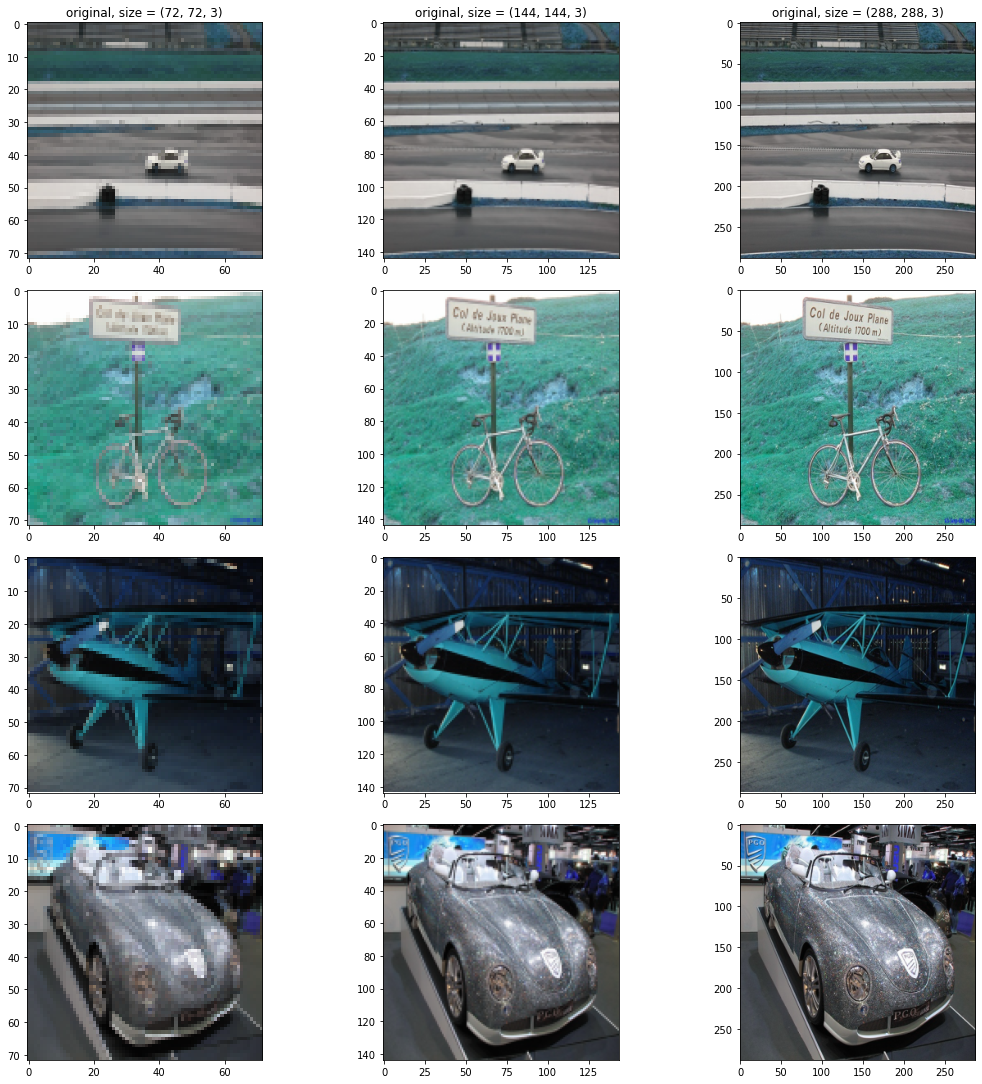

In [44]:
# 绘图函数与超过1行或列，期望图像是一个列表
def plot_images(images,titles = ['original','original','pred144'],figsize=(15,15)):
    nrows = len(images[0])
    ncols = len(images)
    fig, ax = plt.subplots(nrows = nrows,ncols = ncols,figsize=figsize)
    fig.tight_layout()

#     fig.subplots_adjust(hspace=0.3, wspace=0.1)
    for i in range(nrows):
        for j in range(ncols):
            ax[i][j].imshow(images[j][i])
            if i == 0:
                ax[i][j].set_title(titles[j] + ' size = ' + str(images[j][i].shape))
plot_images([img72[0:4],img144[0:4],img288[0:4]],['original,','original,','original,'])

# 模型1

In [45]:
def build_model_step2():
    inp = Input(shape=(72, 72, 3))
    x = Conv2D(64, (3, 3), padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(3, 1,activation = 'sigmoid',padding='same',name = 'output')(x)
    return Model(inputs=inp, outputs=x)

def VGG2():
    inp = Input(shape=(72, 72, 3))
    model = UpSampling2D(size=(2, 2))(inp)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)

    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)

    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)

    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    
    
    res_img = model
    return Model(inputs=inp, outputs=model)

In [46]:
#model1 = build_model_step2()
model1=VGG2()
model1.compile(optimizer='adam', loss='mse',metrics=[PSNR])
model1.summary()
plot_model(model1, to_file='multiple_outputs.png')

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 72, 72, 3)]       0         
                                                                 
 up_sampling2d_16 (UpSamplin  (None, 144, 144, 3)      0         
 g2D)                                                            
                                                                 
 conv2d_126 (Conv2D)         (None, 144, 144, 64)      1792      
                                                                 
 activation_114 (Activation)  (None, 144, 144, 64)     0         
                                                                 
 conv2d_127 (Conv2D)         (None, 144, 144, 64)      36928     
                                                                 
 activation_115 (Activation)  (None, 144, 144, 64)     0         
                                                           

In [47]:
def set_callbacks( name = 'best_model_weights',patience=8,tb_base_logdir='./logs/'):
#     from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
    cp = ModelCheckpoint(name +'.h5',save_best_only=True)
    es = EarlyStopping(patience=patience,monitor='val_loss')
    rlop = ReduceLROnPlateau(patience=patience)
    return [rlop, es, cp]

In [48]:
batch = 64
hist1 = model1.fit_generator(data_generator_val_144(4011,batch),validation_data=data_generator_val_144(1000,batch),
                             validation_steps = 1000//batch, steps_per_epoch= 4011//batch,epochs=10,callbacks = set_callbacks(name = 'best_model1_weights'))

/tmp/ipykernel_1298977/2375034641.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist1 = model1.fit_generator(data_generator_val_144(4011,batch),validation_data=data_generator_val_144(1000,batch),


Epoch 1/10
62/62 [==============================] - 1033s 17s/step - loss: 0.0820 - PSNR: 46.6569 - val_loss: 0.0103 - val_PSNR: 57.6161 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - 1040s 17s/step - loss: 0.0074 - PSNR: 60.3673 - val_loss: 0.0063 - val_PSNR: 59.9367 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - 1038s 17s/step - loss: 0.0052 - PSNR: 63.4705 - val_loss: 0.0041 - val_PSNR: 67.4443 - lr: 0.0010
Epoch 4/10
62/62 [==============================] - 1034s 17s/step - loss: 0.0039 - PSNR: 68.1654 - val_loss: 0.0034 - val_PSNR: 69.1727 - lr: 0.0010
Epoch 5/10
62/62 [==============================] - 1036s 17s/step - loss: 0.0032 - PSNR: 70.7369 - val_loss: 0.0030 - val_PSNR: 70.6496 - lr: 0.0010
Epoch 6/10
62/62 [==============================] - 1033s 17s/step - loss: 0.0030 - PSNR: 70.1728 - val_loss: 0.0028 - val_PSNR: 71.0111 - lr: 0.0010
Epoch 7/10
62/62 [==============================] - 1038s 17s/step - loss: 0.0032 - PSNR: 69.1632 - 

In [49]:
def print_loss_psnr(hist,title_name):
    if len(hist.history.keys()) <= 5:
        plt.plot(hist.history['loss'], 'r', hist.history['val_loss'], 'b')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.title(title_name + ' loss')
        plt.legend(['loss','val_loss'])
        plt.figure()
        plt.plot(hist.history['PSNR'], 'r', hist.history['val_PSNR'], 'b')
        plt.xlabel('Epochs')
        plt.ylabel('PSNR')
        plt.title(title_name + ' PSNR')
        plt.legend(['PSNR','val_PSNR'])
    else:
        plt.plot(hist.history['output1_loss'], 'r', hist.history['output2_loss'], 'b',
                hist.history['val_output1_loss'], 'g', hist.history['val_output2_loss'], 'y')
        plt.xlabel('Epochs')
        plt.ylabel('loss')
        plt.title(title_name + ' loss')
        plt.legend(['output1_loss','output2_loss','val_output1_loss','val_output2_loss'])
        plt.figure()
        plt.plot(hist.history['output1_PSNR'], 'r', hist.history['output2_PSNR'], 'b',
                hist.history['val_output1_PSNR'], 'g', hist.history['val_output2_PSNR'], 'y')
        plt.xlabel('Epochs')
        plt.ylabel('PSNR')
        plt.title(title_name + ' PSNR')
        plt.legend(['output1_PSNR','output2_PSNR','val_output1_PSNR','val_output2_PSNR'])

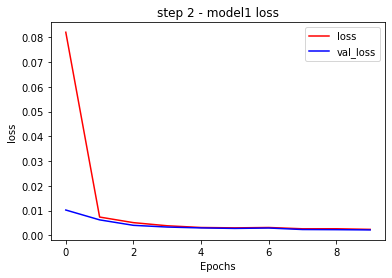

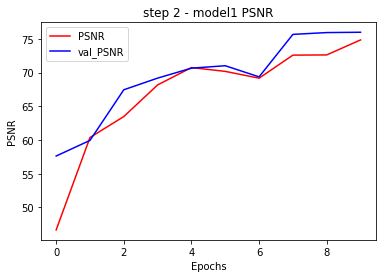

In [50]:
print_loss_psnr(hist = hist1,title_name = 'step 2 - model1')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


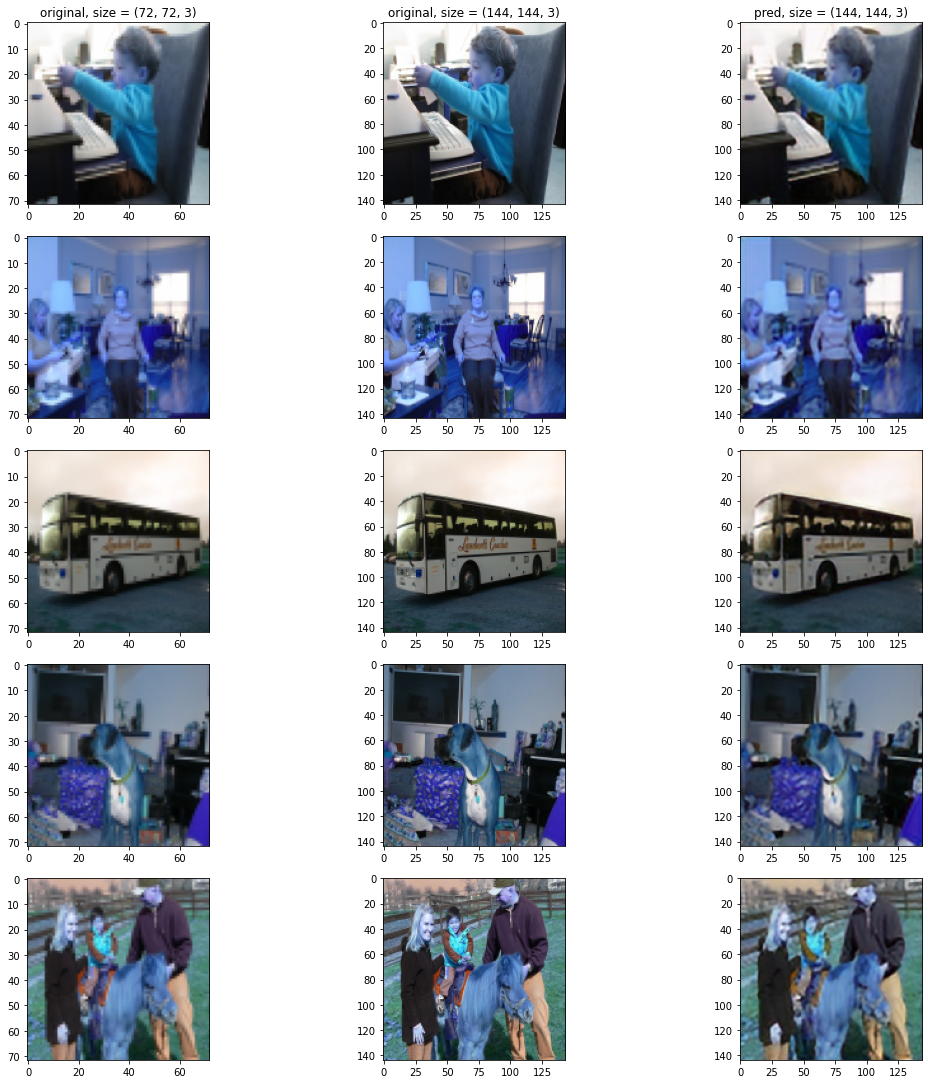

In [51]:
pred144 = model1.predict(img72[80:100])
plot_images([img72[80:85],img144[80:85],pred144[0:5]],titles = ['original,','original,','pred,'])

# 模型2

In [52]:
def build_model_step3():
    inp = Input(shape=(72, 72, 3))
    x = Conv2D(64, (3, 3), padding='same')(inp)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D((2,2))(x)
    out2 = UpSampling2D((2,2))(x)
    out2 = Conv2D(3, 1,activation = 'sigmoid', padding='same',name = 'output2')(out2)
    out1 = Conv2D(3, 1, activation='sigmoid', padding='same',name = 'output1')(x)
    model = Model(inputs=inp, outputs=[out1, out2])
#     model.compile(optimizer='adam', loss='mse',loss_weights = [0.1,0.9])
    return model

def VGG2():
    inp = Input(shape=(72, 72, 3))
    model = UpSampling2D(size=(2, 2))(inp)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)

    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)

    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)

    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    model = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    model = Activation('relu')(model)
    out1 = Conv2D(3, (3, 3), padding='same', kernel_initializer='he_normal')(model)
    out2 = UpSampling2D(size=(2, 2))(out1)
    
    res_img = model
    return Model(inputs=inp, outputs=[out1, out2])

In [53]:
model2 = VGG2()
#model2=build_model_step3()
model2.compile(optimizer='adam', loss='mse',metrics=[PSNR])
model2.summary()
plot_model(model2, to_file='multiple_outputs.png')

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 72, 72, 3)]       0         
                                                                 
 up_sampling2d_17 (UpSamplin  (None, 144, 144, 3)      0         
 g2D)                                                            
                                                                 
 conv2d_146 (Conv2D)         (None, 144, 144, 64)      1792      
                                                                 
 activation_133 (Activation)  (None, 144, 144, 64)     0         
                                                                 
 conv2d_147 (Conv2D)         (None, 144, 144, 64)      36928     
                                                                 
 activation_134 (Activation)  (None, 144, 144, 64)     0         
                                                          

In [54]:
batch = 64
hist2 = model2.fit_generator(data_generator_val_144_288(4011,batch),validation_data=data_generator_val_144_288(1000,batch),
                             validation_steps = 1000//batch, steps_per_epoch= 4011//batch,epochs=10,callbacks = set_callbacks(name = 'best_model2_weights'))

/tmp/ipykernel_1298977/282961176.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist2 = model2.fit_generator(data_generator_val_144_288(4011,batch),validation_data=data_generator_val_144_288(1000,batch),


Epoch 1/10
62/62 [==============================] - 1089s 18s/step - loss: 0.4365 - conv2d_165_loss: 0.2172 - up_sampling2d_18_loss: 0.2193 - conv2d_165_PSNR: 43.6327 - up_sampling2d_18_PSNR: 42.9703 - val_loss: 0.0230 - val_conv2d_165_loss: 0.0105 - val_up_sampling2d_18_loss: 0.0125 - val_conv2d_165_PSNR: 56.9700 - val_up_sampling2d_18_PSNR: 55.6661 - lr: 0.0010
Epoch 2/10
62/62 [==============================] - 1092s 18s/step - loss: 0.0216 - conv2d_165_loss: 0.0097 - up_sampling2d_18_loss: 0.0118 - conv2d_165_PSNR: 56.5796 - up_sampling2d_18_PSNR: 55.2404 - val_loss: 0.0152 - val_conv2d_165_loss: 0.0066 - val_up_sampling2d_18_loss: 0.0086 - val_conv2d_165_PSNR: 60.7859 - val_up_sampling2d_18_PSNR: 59.1527 - lr: 0.0010
Epoch 3/10
62/62 [==============================] - 1093s 18s/step - loss: 0.0112 - conv2d_165_loss: 0.0046 - up_sampling2d_18_loss: 0.0066 - conv2d_165_PSNR: 65.9296 - up_sampling2d_18_PSNR: 63.8571 - val_loss: 0.0092 - val_conv2d_165_loss: 0.0036 - val_up_sampling2d

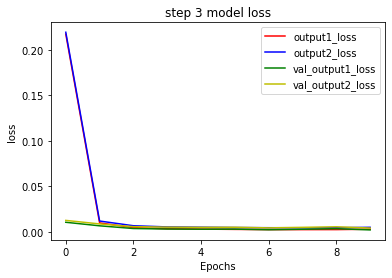

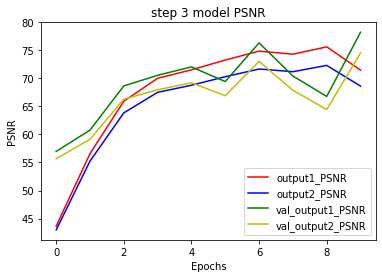

In [58]:
print_loss_psnr1(hist = hist2,title_name = 'step 3 model')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

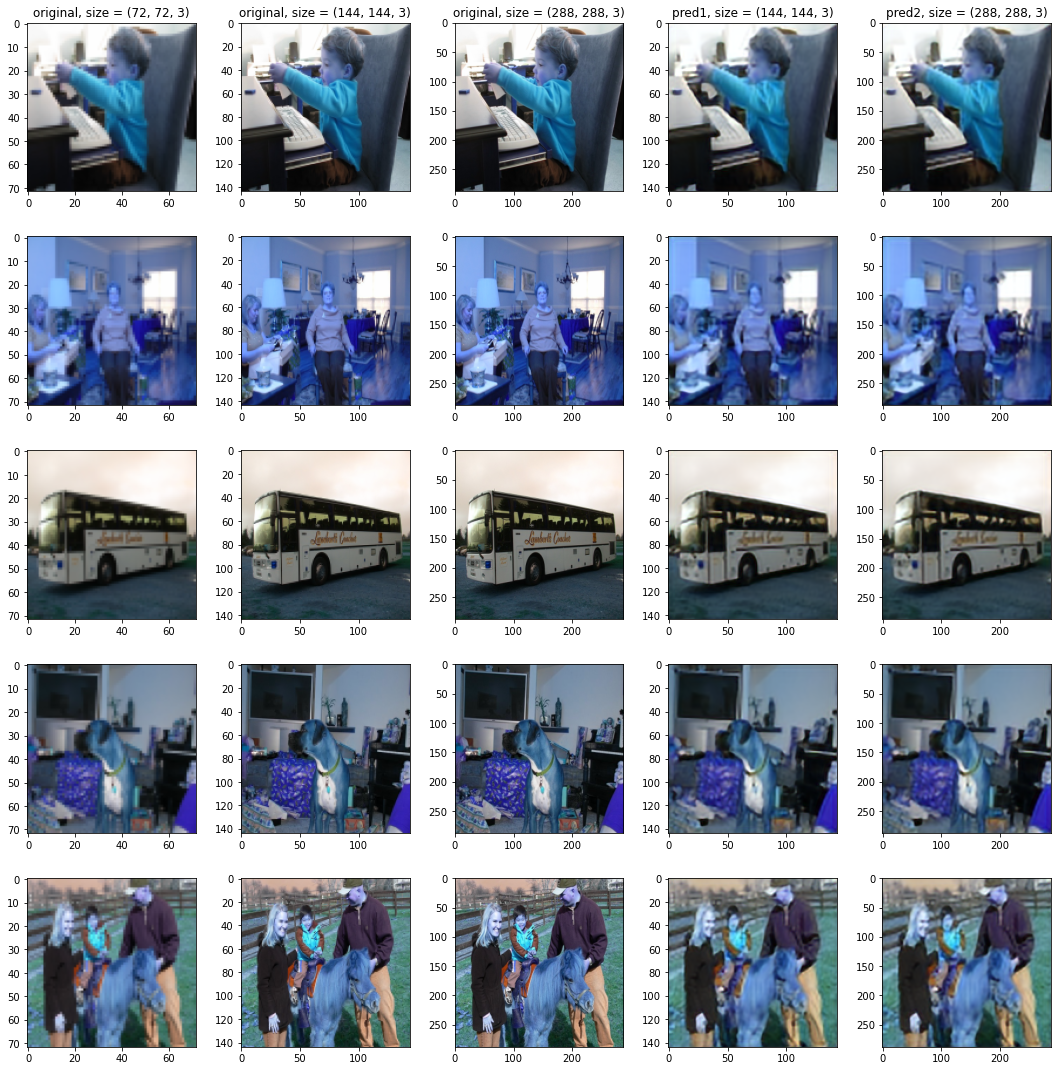

In [56]:
pred2 = model2.predict(img72[80:100])
plot_images([img72[80:85],img144[80:85],img288[80:85],pred2[0][0:5],pred2[1][0:5]],titles = ['original,','original,','original,','pred1,','pred2,'])